In [1]:
import torch
import math
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
import os   
from torch.nn.init import xavier_normal_, xavier_normal
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [2]:
def generate_disc_set(nb):
    # creating the circle in the middle of the points
    axis = torch.FloatTensor(1,2).uniform_(0.5,0.5)
    r = 1/((2*math.pi)**0.5)
    
    train_input   =  torch.FloatTensor(nb, 2).uniform_(0,1)
    train_target  =  torch.FloatTensor(nb, 2)
    train_mask    =  torch.FloatTensor(nb, 1)
    test_input    =  torch.FloatTensor(nb, 2).uniform_(0,1)
    test_target   =  torch.FloatTensor(nb, 2)
    test_mask     =  torch.FloatTensor(nb, 1)
    
    for i in range(0, len(train_input)):
        a = abs((train_input[i] - axis).pow(2).sum(1).view(-1).pow(0.5))
        b = abs((test_input[i]  - axis).pow(2).sum(1).view(-1).pow(0.5))
    
        if a < r:
            train_target[i][0] = 0
            train_target[i][1] = 1
            train_mask[i]      = 1
        else:
            train_target[i][0] = 1
            train_target[i][1] = 0
            train_mask[i]      = 0
            
        if b < r:
            test_target[i][0] = 0
            test_target[i][1] = 1
            test_mask[i]      = 1
        else:
            test_target[i][0] = 1
            test_target[i][1] = 0
            test_mask[i]      = 0
        
    return train_input, train_target, test_input, test_target, test_mask, train_mask

In [3]:
train_input, train_target, test_input, test_target, test_mask, train_mask = generate_disc_set(1000)

In [4]:
train_scatter = torch.cat((train_input, train_mask),1)
train_scatter_false = train_scatter[train_scatter[:,2] == 0]
train_scatter_true = train_scatter[train_scatter[:,2] == 1]

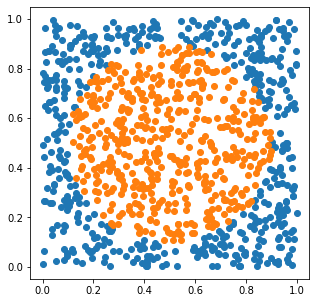

In [5]:
plt.figure(figsize=(5, 5))
plt.scatter(train_scatter_false[:,0], train_scatter_false[:,1], )
plt.scatter(train_scatter_true[:,0], train_scatter_true[:,1], )

In [6]:
def ReLu(x):
    return x.clamp(min=0)

def dReLu(x):
    return (torch.sign(x) + 1)/2

In [7]:
def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)

In [8]:
def sigma(x):
    return x.tanh()

def dsigma(x):
    return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

In [9]:
def forward_pass(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x0, s1, x1, s2, x2, s3, x3

def backward_pass(w1, b1, w2, b2, w3, b3,
                  t,
                  x, s1, x1, s2, x2, s3, x3,
                  dl_dw1, dl_db1, dl_dw2, dl_db2,dl_dw3,dl_db3):
    x0 = x
    dl_dx3 = dloss(x3, t)
    dl_ds3 = dReLu(s3) * dl_dx3
    
    dl_dx2 = w3.t().mv(dl_ds3)
    dl_ds2 = dReLu(s2) * dl_dx2
    
    dl_dx1 = w2.t().mv(dl_ds2)
    dl_ds1 = dReLu(s1) * dl_dx1
    
    
    dl_dw3.add_(dl_ds3.view(-1, 1).mm(x2.view(1, -1)))
    dl_db3.add_(dl_ds3) 

    dl_dw2.add_(dl_ds2.view(-1, 1).mm(x1.view(1, -1)))
    dl_db2.add_(dl_ds2)
    
    dl_dw1.add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_db1.add_(dl_ds1)

######################################################################

nb_classes = train_target.size(1)
nb_train_samples = train_input.size(0)

zeta = 1

train_target = train_target * zeta
test_target = test_target * zeta

nb_hidden = 25
eta = 0.0005
epsilon = 1e-3

#SGD momentum
momentum = 0

#weights and biases
w1 = xavier_normal_(torch.empty(nb_hidden, train_input.size(1)).normal_(0, epsilon))
b1 = torch.empty(nb_hidden).normal_(0, epsilon)

w2 = xavier_normal_(torch.empty(nb_hidden, nb_hidden).normal_(0, epsilon))
b2 = torch.empty(nb_hidden).normal_(0, epsilon)

w3 = xavier_normal_(torch.empty(nb_classes, nb_hidden).normal_(0, epsilon))
b3 = torch.empty(nb_classes).normal_(0, epsilon)


#Gradient
dl_dw1 = torch.empty(w1.size())
dl_db1 = torch.empty(b1.size())

dl_dw2 = torch.empty(w2.size())
dl_db2 = torch.empty(b2.size())

dl_dw3 = torch.empty(w3.size())
dl_db3 = torch.empty(b3.size())


# SGD velocities
velocity_w1 = torch.empty(w1.size())
velocity_b1 = torch.empty(b1.size())

velocity_w2 = torch.empty(w2.size())
velocity_b2 = torch.empty(b2.size())

velocity_w3 = torch.empty(w3.size())
velocity_b3 = torch.empty(b3.size())







for k in range(1000):

    # Back-prop

    acc_loss = 0
    nb_train_errors = 0

    dl_dw1.zero_()
    dl_db1.zero_()
    
    dl_dw2.zero_()
    dl_db2.zero_()
    
    dl_dw3.zero_()
    dl_db3.zero_()

    for n in range(nb_train_samples):
        x0, s1, x1, s2, x2, s3, x3 = forward_pass(w1, b1, w2, b2, w3, b3, train_input[n])

        
        pred = x3.max(0)[1].item()
        target = 0
        if train_target[n][0] == 0 : target = 1
        if target != pred : nb_train_errors = nb_train_errors + 1
        acc_loss = acc_loss + loss(x3, train_target[n])
        

        backward_pass(w1, b1, w2, b2,w3,b3,
                      train_target[n],
                      x0, s1, x1, s2, x2,s3,x3,
                      dl_dw1, dl_db1, dl_dw2, dl_db2,dl_dw3,dl_db3)

    # SGD
    
    velocity_w1 = momentum * velocity_w1 - eta * dl_dw1
    w1 = w1 + velocity_w1
    
    velocity_b1 = momentum * velocity_b1 - eta * dl_db1
    b1 = b1 + velocity_b1
    
    
    velocity_w2 = momentum * velocity_w2 - eta * dl_dw2
    w2 = w2 + velocity_w2
    
    velocity_b2 = momentum * velocity_b2 - eta * dl_db2
    b2 = b2 + velocity_b2
    
    
    velocity_w3 = momentum * velocity_w3 - eta * dl_dw3
    w3 = w3 + velocity_w3
    
    velocity_b3 = momentum * velocity_b3 - eta * dl_db3
    b3 = b3 + velocity_b3
    
    
    #### SGD towerds data science
    #velocity_w1 = momentum * velocity_w1 + dl_dw1
    #w1 = w1 - eta * velocity_w1
    
    #velocity_b1 = momentum * velocity_b1 + dl_db1
    #b1 = b1 - eta * velocity_b1 
    
    
    #velocity_w2 = momentum * velocity_w2 + dl_dw2
    #w2 = w2 - eta * velocity_w2
    
    #velocity_b2 = momentum * velocity_b2 + dl_db2
    #b2 = b2 - eta * velocity_b2 
    
    
    #velocity_w3 = momentum * velocity_w3 + dl_dw3
    #w3 = w3 - eta * velocity_w3
    
    #velocity_b3 = momentum * velocity_b3 + dl_db3
    #b3 = b3 - eta * velocity_b3 
    

    ### Normal gradient step
    #w1 = w1 - eta * dl_dw1
    #b1 = b1 - eta * dl_db1
    
    #w2 = w2 - eta * dl_dw2
    #b2 = b2 - eta * dl_db2
    
    #w3 = w3 - eta * dl_dw3
    #b3 = b3 - eta * dl_db3
    
    
    
    
    

    # Test error

    nb_test_errors = 0

    for n in range(test_input.size(0)):
        _, _, _, _,_,_, x3 = forward_pass(w1, b1, w2, b2,w3,b3, test_input[n])

        pred = x3.max(0)[1].item()
        target = 0
        if test_target[n][0] == 0 : target = 1
        if target != pred : nb_test_errors = nb_test_errors + 1

    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(k,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

0 acc_train_loss 979.39 acc_train_error 54.90% test_error 49.50%
1 acc_train_loss 870.98 acc_train_error 50.60% test_error 49.50%
2 acc_train_loss 917.50 acc_train_error 50.60% test_error 49.50%
3 acc_train_loss 764.12 acc_train_error 50.60% test_error 49.50%
4 acc_train_loss 756.07 acc_train_error 50.60% test_error 49.50%
5 acc_train_loss 753.50 acc_train_error 50.60% test_error 49.50%
6 acc_train_loss 752.65 acc_train_error 50.60% test_error 49.50%
7 acc_train_loss 751.87 acc_train_error 50.60% test_error 49.50%
8 acc_train_loss 751.11 acc_train_error 50.60% test_error 49.50%
9 acc_train_loss 750.42 acc_train_error 50.60% test_error 49.50%
10 acc_train_loss 749.81 acc_train_error 50.60% test_error 49.50%
11 acc_train_loss 749.23 acc_train_error 50.60% test_error 49.50%
12 acc_train_loss 748.66 acc_train_error 50.60% test_error 49.50%
13 acc_train_loss 748.10 acc_train_error 50.60% test_error 49.50%
14 acc_train_loss 747.55 acc_train_error 50.60% test_error 49.50%
15 acc_train_loss 74

124 acc_train_loss 548.41 acc_train_error 47.90% test_error 38.60%
125 acc_train_loss 461.28 acc_train_error 37.50% test_error 43.30%
126 acc_train_loss 489.74 acc_train_error 44.80% test_error 35.60%
127 acc_train_loss 412.98 acc_train_error 32.60% test_error 35.00%
128 acc_train_loss 428.75 acc_train_error 37.50% test_error 33.40%
129 acc_train_loss 384.31 acc_train_error 30.30% test_error 29.10%
130 acc_train_loss 400.24 acc_train_error 33.80% test_error 32.30%
131 acc_train_loss 379.11 acc_train_error 29.90% test_error 32.40%
132 acc_train_loss 417.94 acc_train_error 35.50% test_error 33.20%
133 acc_train_loss 387.59 acc_train_error 30.70% test_error 32.40%
134 acc_train_loss 431.65 acc_train_error 36.90% test_error 33.70%
135 acc_train_loss 390.42 acc_train_error 30.40% test_error 33.50%
136 acc_train_loss 439.04 acc_train_error 37.30% test_error 32.90%
137 acc_train_loss 384.76 acc_train_error 30.10% test_error 32.50%
138 acc_train_loss 418.48 acc_train_error 36.50% test_error 32

247 acc_train_loss 281.48 acc_train_error 22.50% test_error 37.70%
248 acc_train_loss 476.39 acc_train_error 38.70% test_error 34.00%
249 acc_train_loss 480.68 acc_train_error 31.90% test_error 48.30%
250 acc_train_loss 672.69 acc_train_error 49.40% test_error 24.00%
251 acc_train_loss 317.84 acc_train_error 21.20% test_error 23.90%
252 acc_train_loss 319.02 acc_train_error 27.00% test_error 21.00%
253 acc_train_loss 269.46 acc_train_error 19.40% test_error 28.10%
254 acc_train_loss 394.70 acc_train_error 28.80% test_error 16.40%
255 acc_train_loss 221.67 acc_train_error 16.10% test_error 17.50%
256 acc_train_loss 247.54 acc_train_error 20.80% test_error 19.30%
257 acc_train_loss 243.55 acc_train_error 18.30% test_error 25.80%
258 acc_train_loss 349.25 acc_train_error 26.90% test_error 19.90%
259 acc_train_loss 240.71 acc_train_error 18.80% test_error 23.60%
260 acc_train_loss 326.22 acc_train_error 26.00% test_error 21.40%
261 acc_train_loss 249.69 acc_train_error 19.60% test_error 23

370 acc_train_loss 313.37 acc_train_error 25.10% test_error 20.30%
371 acc_train_loss 253.82 acc_train_error 19.90% test_error 21.40%
372 acc_train_loss 300.36 acc_train_error 24.40% test_error 19.70%
373 acc_train_loss 249.26 acc_train_error 19.70% test_error 21.00%
374 acc_train_loss 298.17 acc_train_error 23.10% test_error 19.40%
375 acc_train_loss 245.32 acc_train_error 19.20% test_error 20.50%
376 acc_train_loss 293.49 acc_train_error 22.50% test_error 19.20%
377 acc_train_loss 239.15 acc_train_error 18.50% test_error 20.60%
378 acc_train_loss 286.56 acc_train_error 21.90% test_error 19.10%
379 acc_train_loss 236.84 acc_train_error 18.30% test_error 20.40%
380 acc_train_loss 283.26 acc_train_error 21.50% test_error 19.40%
381 acc_train_loss 241.08 acc_train_error 18.40% test_error 20.90%
382 acc_train_loss 287.97 acc_train_error 22.40% test_error 19.70%
383 acc_train_loss 249.83 acc_train_error 19.10% test_error 21.70%
384 acc_train_loss 301.23 acc_train_error 23.50% test_error 19

493 acc_train_loss 217.26 acc_train_error 15.70% test_error 18.30%
494 acc_train_loss 266.37 acc_train_error 19.10% test_error 14.80%
495 acc_train_loss 202.43 acc_train_error 14.30% test_error 17.00%
496 acc_train_loss 246.98 acc_train_error 17.50% test_error 13.70%
497 acc_train_loss 193.55 acc_train_error 13.60% test_error 16.20%
498 acc_train_loss 242.30 acc_train_error 17.50% test_error 11.70%
499 acc_train_loss 177.23 acc_train_error 12.70% test_error 14.90%
500 acc_train_loss 219.59 acc_train_error 15.70% test_error 10.80%
501 acc_train_loss 171.14 acc_train_error 12.20% test_error 16.10%
502 acc_train_loss 223.77 acc_train_error 16.80% test_error 12.20%
503 acc_train_loss 177.24 acc_train_error 13.90% test_error 17.90%
504 acc_train_loss 232.13 acc_train_error 18.30% test_error 13.00%
505 acc_train_loss 175.01 acc_train_error 13.50% test_error 16.10%
506 acc_train_loss 204.77 acc_train_error 16.10% test_error 14.70%
507 acc_train_loss 182.72 acc_train_error 13.90% test_error 16

616 acc_train_loss 208.76 acc_train_error 14.30% test_error 11.00%
617 acc_train_loss 153.67 acc_train_error 10.00% test_error 13.60%
618 acc_train_loss 194.91 acc_train_error 13.90% test_error 11.20%
619 acc_train_loss 157.98 acc_train_error 10.20% test_error 15.10%
620 acc_train_loss 214.68 acc_train_error 15.20% test_error 11.10%
621 acc_train_loss 167.81 acc_train_error 11.00% test_error 16.60%
622 acc_train_loss 234.59 acc_train_error 16.70% test_error 11.20%
623 acc_train_loss 171.31 acc_train_error 11.60% test_error 15.20%
624 acc_train_loss 240.94 acc_train_error 17.80% test_error 12.00%
625 acc_train_loss 181.47 acc_train_error 12.40% test_error 15.00%
626 acc_train_loss 246.51 acc_train_error 18.00% test_error 11.90%
627 acc_train_loss 167.79 acc_train_error 11.80% test_error 11.80%
628 acc_train_loss 206.22 acc_train_error 14.60% test_error 12.30%
629 acc_train_loss 174.65 acc_train_error 12.10% test_error 13.80%
630 acc_train_loss 224.39 acc_train_error 15.40% test_error 12

739 acc_train_loss 152.13 acc_train_error 10.90% test_error 13.60%
740 acc_train_loss 178.06 acc_train_error 13.20% test_error 12.60%
741 acc_train_loss 163.22 acc_train_error 12.50% test_error 13.30%
742 acc_train_loss 174.90 acc_train_error 13.20% test_error 13.00%
743 acc_train_loss 165.39 acc_train_error 11.80% test_error 12.40%
744 acc_train_loss 163.27 acc_train_error 11.80% test_error 12.70%
745 acc_train_loss 162.26 acc_train_error 11.70% test_error 11.50%
746 acc_train_loss 155.07 acc_train_error 10.90% test_error 12.60%
747 acc_train_loss 160.25 acc_train_error 11.40% test_error 10.40%
748 acc_train_loss 150.82 acc_train_error 10.20% test_error 11.90%
749 acc_train_loss 159.89 acc_train_error 11.30% test_error 10.50%
750 acc_train_loss 149.07 acc_train_error 10.00% test_error 11.90%
751 acc_train_loss 159.45 acc_train_error 11.00% test_error 10.60%
752 acc_train_loss 146.53 acc_train_error 9.80% test_error 11.50%
753 acc_train_loss 156.49 acc_train_error 10.80% test_error 10.

862 acc_train_loss 143.37 acc_train_error 10.20% test_error 9.60%
863 acc_train_loss 127.36 acc_train_error 8.60% test_error 9.90%
864 acc_train_loss 142.50 acc_train_error 10.00% test_error 9.00%
865 acc_train_loss 126.36 acc_train_error 9.00% test_error 10.20%
866 acc_train_loss 154.57 acc_train_error 10.30% test_error 8.70%
867 acc_train_loss 128.13 acc_train_error 8.20% test_error 11.40%
868 acc_train_loss 166.85 acc_train_error 11.90% test_error 8.20%
869 acc_train_loss 128.81 acc_train_error 7.90% test_error 11.80%
870 acc_train_loss 173.87 acc_train_error 12.20% test_error 8.50%
871 acc_train_loss 134.84 acc_train_error 8.40% test_error 12.90%
872 acc_train_loss 188.56 acc_train_error 13.10% test_error 10.10%
873 acc_train_loss 145.60 acc_train_error 9.20% test_error 13.80%
874 acc_train_loss 211.41 acc_train_error 14.20% test_error 11.00%
875 acc_train_loss 156.60 acc_train_error 9.70% test_error 13.80%
876 acc_train_loss 218.92 acc_train_error 14.30% test_error 11.20%
877 acc_

986 acc_train_loss 169.98 acc_train_error 10.30% test_error 14.40%
987 acc_train_loss 234.96 acc_train_error 16.10% test_error 12.80%
988 acc_train_loss 195.22 acc_train_error 11.80% test_error 18.20%
989 acc_train_loss 270.51 acc_train_error 19.60% test_error 13.30%
990 acc_train_loss 206.70 acc_train_error 12.50% test_error 17.70%
991 acc_train_loss 265.22 acc_train_error 19.40% test_error 12.70%
992 acc_train_loss 189.15 acc_train_error 11.90% test_error 14.90%
993 acc_train_loss 230.69 acc_train_error 17.00% test_error 12.50%
994 acc_train_loss 178.67 acc_train_error 11.40% test_error 13.60%
995 acc_train_loss 218.40 acc_train_error 15.50% test_error 12.20%
996 acc_train_loss 172.41 acc_train_error 10.50% test_error 12.80%
997 acc_train_loss 210.49 acc_train_error 14.00% test_error 11.60%
998 acc_train_loss 166.32 acc_train_error 10.20% test_error 12.30%
999 acc_train_loss 202.18 acc_train_error 13.50% test_error 11.30%
